X_train shape is increasing that is (n++, 128, 128, 3) and we create batches with similar shapes of X_train

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import random
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [3]:
n = 2
imgsize1 = 128
imgsize2 = 128

In [4]:
def activation_tanh(x):
    return 100 * tf.math.tanh(x)

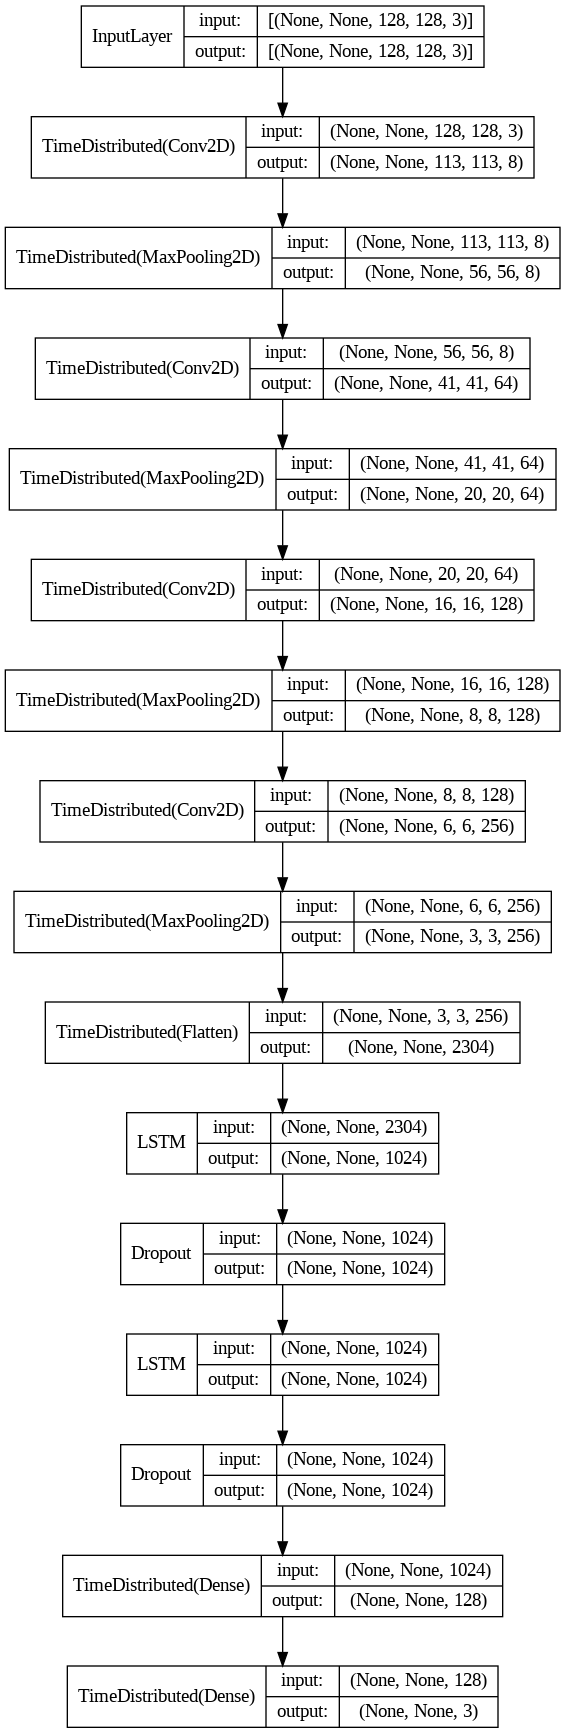

In [5]:
model = Sequential()
model.add(tf.keras.layers.TimeDistributed(Conv2D(8, kernel_size=16, activation=tf.keras.layers.LeakyReLU(alpha=0.4)), input_shape = (None, imgsize1, imgsize2, 3)))
model.add(tf.keras.layers.TimeDistributed(MaxPooling2D()))
model.add(tf.keras.layers.TimeDistributed(Conv2D(64, kernel_size=16, activation=tf.keras.layers.LeakyReLU(alpha=0.4))))
model.add(tf.keras.layers.TimeDistributed(MaxPooling2D()))
model.add(tf.keras.layers.TimeDistributed(Conv2D(128, kernel_size=5, activation=tf.keras.layers.LeakyReLU(alpha=0.4))))
model.add(tf.keras.layers.TimeDistributed(MaxPooling2D()))
model.add(tf.keras.layers.TimeDistributed(Conv2D(256, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.4))))
model.add(tf.keras.layers.TimeDistributed(MaxPooling2D()))
model.add(tf.keras.layers.TimeDistributed(Flatten()))
model.add(tf.keras.layers.LSTM(1024, return_sequences = True))
model.add(Dropout(0.2))
model.add(tf.keras.layers.LSTM(1024, return_sequences = True))
model.add(Dropout(0.2))
model.add(tf.keras.layers.TimeDistributed(Dense(128, activation=activation_tanh)))
model.add(tf.keras.layers.TimeDistributed(Dense(3, activation='linear')))
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [6]:
model.compile(optimizer='rmsprop', loss='mse')

In [7]:
def R_Square(Y, Y_pred) :
  return 1 - (np.sum((Y-Y_pred)*(Y-Y_pred)))/(np.sum((Y - np.mean(Y))*(Y - np.mean(Y))))
def RMSE(Y, Y_pred) :
  return np.sqrt(np.mean((Y - Y_pred)*(Y - Y_pred)))
def RMSEDrift(Y, Y_pred) :
  return np.sqrt(np.mean((Y - Y_pred)*(Y - Y_pred)))/(np.mean(Y))

In [ ]:
def get_X(i, count2) :
  X = np.zeros((count2,imgsize1,imgsize2,3))
  if i == 2 or i == 3 or i == 15 or i == 16 :
    vidcap = cv2.VideoCapture('gdrive/My Drive/FYP-Data/Scenes Videos/{}/Basic _FirstMP4.avi'.format(i))
  else :
    vidcap = cv2.VideoCapture('gdrive/My Drive/FYP-Data/Scenes Videos/{}/Basic _FirstMP4.mp4'.format(i))
  count = 0
  while count<count2 :  
    success, image = vidcap.read()
    img = cv2.resize(image, (imgsize2,imgsize1))
    X[count,:,:,:] = np.copy(img)
    count += 1
  return X
def data_loader(i, n) :
  count2 = n
  X_train = get_X(i, count2)
  X_val = get_X(i+12, count2)
  Y_train = np.zeros((count2, 3))
  Y_val = np.zeros((count2, 3))
  Y_train[:,:] = np.array(pd.read_excel('gdrive/My Drive/FYP-Data/Scene Pos/{}/PositionData.xlsx'.format(i))).T[0:count2,:]
  Y_val[:,:] = np.array(pd.read_excel('gdrive/My Drive/FYP-Data/Scene Pos/{}/PositionData.xlsx'.format(i+12))).T[0:count2,:]
  print(Y_train.shape, X_train.shape, "Training Shape", Y_val.shape, X_val.shape, "Validation Shape")
  return Y_train, Y_val, X_train, X_val
for n in range(350, 451, 10) :
  X_train = np.zeros((12, n, imgsize1, imgsize2, 3))
  X_val = np.zeros((12, n, imgsize1, imgsize2, 3))
  Y_train = np.zeros((12, n, 3))
  Y_val = np.zeros((12, n, 3))
  for i in range(1,13) :
    print("Data from folder", i)
    Y_t, Y_v, X_t, X_v = data_loader(i, n)
    X_train[i-1, :, :, :] = np.copy(X_t)
    Y_train[i-1, :, :] = np.copy(Y_t)
    X_val[i-1, :, :, :] = np.copy(X_v)
    Y_val[i-1, :, :] = np.copy(Y_v)
    print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
    print(n)
    if i == 12 :
      model.load_weights('gdrive/My Drive/FYP-Data/Model_weights_temp_10')
      history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=2, epochs=100)
      model.save_weights('gdrive/My Drive/FYP-Data/Model_weights_temp_10')
      Y_pred = model.predict(X_train)
      Y_pred_val = model.predict(X_val)
      print(R_Square(Y_train[:, :, 0:2], Y_pred[:, :, 0:2]), R_Square(Y_val[:, :, 0:2], Y_pred_val[:, :, 0:2]), 'R_square')
      print(RMSE(Y_train[:, :, 0:2], Y_pred[:, :, 0:2]), RMSE(Y_val[:, :, 0:2], Y_pred_val[:, :, 0:2]), 'RMSE')
      print(RMSEDrift(Y_train[:, :, 0:2], Y_pred[:, :, 0:2]), RMSEDrift(Y_val[:, :, 0:2], Y_pred_val[:, :, 0:2]), 'RMSEDrift')
      print(R_Square(Y_train, Y_pred), R_Square(Y_val, Y_pred_val), 'R_square_full')
      print(RMSE(Y_train, Y_pred), RMSE(Y_val, Y_pred_val), 'RMSE_full')
      print(RMSEDrift(Y_train, Y_pred), RMSEDrift(Y_val, Y_pred_val), 'RMSEDrift_full')
      for i in [0.01, 0.05, 0.1, 0.5, 1, 5, 10] :
        print(np.sum(np.abs(np.abs(Y_train[:, :, 0:2]) - np.abs(Y_pred[:, :, 0:2])) < i)/(Y_train.shape[0]*Y_train.shape[1]*2), "For {} training".format(i))
        print(np.sum(np.abs(np.abs(Y_val[:, :, 0:2]) - np.abs(Y_pred_val[:, :, 0:2])) < i)/(Y_val.shape[0]*Y_val.shape[1]*2), "For {} validation".format(i))
      if n%20 == 0 :
        for i in range(0,12) :
          X_axis = range(1,n+1)
          print(np.mean(Y_train[i,:,1]), np.mean(Y_train[i,:,0]), np.mean(Y_train[i,:,2]))
          print(np.mean(Y_val[i,:,1]), np.mean(Y_val[i,:,0]), np.mean(Y_val[i,:,2]))
          plt.scatter(X_axis, Y_train[i,:,1], c ="blue")
          plt.scatter(X_axis, Y_pred[i,:,1], c ="red")
          plt.show()
          plt.scatter(X_axis, Y_train[i,:,0], c ="blue")
          plt.scatter(X_axis, Y_pred[i,:,0], c ="red")
          plt.show()
          plt.scatter(X_axis, Y_train[i,:,2], c ="blue")
          plt.scatter(X_axis, Y_pred[i,:,2], c ="red")
          plt.show()
          X_axis = range(1,n+1)
          plt.scatter(X_axis, Y_pred_val[i,:,1], c ="red")
          plt.scatter(X_axis, Y_val[i,:,1], c ="blue")
          plt.show()
          plt.scatter(X_axis, Y_pred_val[i,:,0], c ="red")
          plt.scatter(X_axis, Y_val[i,:,0], c ="blue")
          plt.show()
          plt.scatter(X_axis, Y_pred_val[i,:,2], c ="red")
          plt.scatter(X_axis, Y_val[i,:,2], c ="blue")
          plt.show()   

Data from folder 1
(350, 3) (350, 128, 128, 3) Training Shape (350, 3) (350, 128, 128, 3) Validation Shape
(12, 350, 128, 128, 3) (12, 350, 3) (12, 350, 128, 128, 3) (12, 350, 3)
350
Data from folder 2
(350, 3) (350, 128, 128, 3) Training Shape (350, 3) (350, 128, 128, 3) Validation Shape
(12, 350, 128, 128, 3) (12, 350, 3) (12, 350, 128, 128, 3) (12, 350, 3)
350
Data from folder 3
(350, 3) (350, 128, 128, 3) Training Shape (350, 3) (350, 128, 128, 3) Validation Shape
(12, 350, 128, 128, 3) (12, 350, 3) (12, 350, 128, 128, 3) (12, 350, 3)
350
Data from folder 4
(350, 3) (350, 128, 128, 3) Training Shape (350, 3) (350, 128, 128, 3) Validation Shape
(12, 350, 128, 128, 3) (12, 350, 3) (12, 350, 128, 128, 3) (12, 350, 3)
350
Data from folder 5
(350, 3) (350, 128, 128, 3) Training Shape (350, 3) (350, 128, 128, 3) Validation Shape
(12, 350, 128, 128, 3) (12, 350, 3) (12, 350, 128, 128, 3) (12, 350, 3)
350
Data from folder 6
(350, 3) (350, 128, 128, 3) Training Shape (350, 3) (350, 128, 128

In [8]:
# Generating X_train and Y_train dataset
def get_X(i, count2) :
  X = np.zeros((count2,imgsize1,imgsize2,3))
  if i == 2 or i == 3 or i == 15 or i == 16 :
    vidcap = cv2.VideoCapture('gdrive/My Drive/FYP-Data/Scenes Videos/{}/Basic _FirstMP4.avi'.format(i))
  else :
    vidcap = cv2.VideoCapture('gdrive/My Drive/FYP-Data/Scenes Videos/{}/Basic _FirstMP4.mp4'.format(i))
  count = 0
  while count<count2 :  
    success, image = vidcap.read()
    img = cv2.resize(image, (imgsize2,imgsize1))
    X[count,:,:,:] = np.copy(img)
    count += 1
  return X
def data_loader(i, n) :
  count2 = n
  X_train = get_X(i, count2)
  X_val = get_X(i+12, count2)
  Y_train = np.zeros((count2, 3))
  Y_val = np.zeros((count2, 3))
  Y_train[:,:] = np.array(pd.read_excel('gdrive/My Drive/FYP-Data/Scene Pos/{}/PositionData.xlsx'.format(i))).T[0:count2,:]
  Y_val[:,:] = np.array(pd.read_excel('gdrive/My Drive/FYP-Data/Scene Pos/{}/PositionData.xlsx'.format(i+12))).T[0:count2,:]
  print(Y_train.shape, X_train.shape, "Training Shape", Y_val.shape, X_val.shape, "Validation Shape")
  return Y_train, Y_val, X_train, X_val
for n in range(350, 351, 10) :
  X_train = np.zeros((12, n, imgsize1, imgsize2, 3))
  X_val = np.zeros((12, n, imgsize1, imgsize2, 3))
  Y_train = np.zeros((12, n, 3))
  Y_val = np.zeros((12, n, 3))
  for i in range(1,13) :
    print("Data from folder", i)
    Y_t, Y_v, X_t, X_v = data_loader(i, n)
    X_train[i-1, :, :, :] = np.copy(X_t)
    Y_train[i-1, :, :] = np.copy(Y_t)
    X_val[i-1, :, :, :] = np.copy(X_v)
    Y_val[i-1, :, :] = np.copy(Y_v)
    print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
    print(n)
    if i == 12 :
      model.load_weights('gdrive/My Drive/FYP-Data/Model_weights_temp_10')
      # history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=2, epochs=100)
      # model.save_weights('gdrive/My Drive/FYP-Data/Model_weights_temp_10')
      Y_pred = model.predict(X_train)
      Y_pred_val = model.predict(X_val)
      print(R_Square(Y_train[:, :, 0:2], Y_pred[:, :, 0:2]), R_Square(Y_val[:, :, 0:2], Y_pred_val[:, :, 0:2]), 'R_square')
      print(RMSE(Y_train[:, :, 0:2], Y_pred[:, :, 0:2]), RMSE(Y_val[:, :, 0:2], Y_pred_val[:, :, 0:2]), 'RMSE')
      print(RMSEDrift(Y_train[:, :, 0:2], Y_pred[:, :, 0:2]), RMSEDrift(Y_val[:, :, 0:2], Y_pred_val[:, :, 0:2]), 'RMSEDrift')
      print(R_Square(Y_train, Y_pred), R_Square(Y_val, Y_pred_val), 'R_square_full')
      print(RMSE(Y_train, Y_pred), RMSE(Y_val, Y_pred_val), 'RMSE_full')
      print(RMSEDrift(Y_train, Y_pred), RMSEDrift(Y_val, Y_pred_val), 'RMSEDrift_full')
      for i in [0.01, 0.05, 0.1, 0.5, 1, 5, 10] :
        print(np.sum(np.abs(np.abs(Y_train[:, :, 0:2]) - np.abs(Y_pred[:, :, 0:2])) < i)/(Y_train.shape[0]*Y_train.shape[1]*2), "For {} training".format(i))
        print(np.sum(np.abs(np.abs(Y_val[:, :, 0:2]) - np.abs(Y_pred_val[:, :, 0:2])) < i)/(Y_val.shape[0]*Y_val.shape[1]*2), "For {} validation".format(i))
      if n%20 == 0 :
        for i in range(0,12) :
          X_axis = range(1,n+1)
          print(np.mean(Y_train[i,:,1]), np.mean(Y_train[i,:,0]), np.mean(Y_train[i,:,2]))
          print(np.mean(Y_val[i,:,1]), np.mean(Y_val[i,:,0]), np.mean(Y_val[i,:,2]))
          plt.scatter(X_axis, Y_train[i,:,1], c ="blue")
          plt.scatter(X_axis, Y_pred[i,:,1], c ="red")
          plt.show()
          plt.scatter(X_axis, Y_train[i,:,0], c ="blue")
          plt.scatter(X_axis, Y_pred[i,:,0], c ="red")
          plt.show()
          plt.scatter(X_axis, Y_train[i,:,2], c ="blue")
          plt.scatter(X_axis, Y_pred[i,:,2], c ="red")
          plt.show()
          X_axis = range(1,n+1)
          plt.scatter(X_axis, Y_pred_val[i,:,1], c ="red")
          plt.scatter(X_axis, Y_val[i,:,1], c ="blue")
          plt.show()
          plt.scatter(X_axis, Y_pred_val[i,:,0], c ="red")
          plt.scatter(X_axis, Y_val[i,:,0], c ="blue")
          plt.show()
          plt.scatter(X_axis, Y_pred_val[i,:,2], c ="red")
          plt.scatter(X_axis, Y_val[i,:,2], c ="blue")
          plt.show()   

Data from folder 1
(350, 3) (350, 128, 128, 3) Training Shape (350, 3) (350, 128, 128, 3) Validation Shape
(12, 350, 128, 128, 3) (12, 350, 3) (12, 350, 128, 128, 3) (12, 350, 3)
350
Data from folder 2
(350, 3) (350, 128, 128, 3) Training Shape (350, 3) (350, 128, 128, 3) Validation Shape
(12, 350, 128, 128, 3) (12, 350, 3) (12, 350, 128, 128, 3) (12, 350, 3)
350
Data from folder 3
(350, 3) (350, 128, 128, 3) Training Shape (350, 3) (350, 128, 128, 3) Validation Shape
(12, 350, 128, 128, 3) (12, 350, 3) (12, 350, 128, 128, 3) (12, 350, 3)
350
Data from folder 4
(350, 3) (350, 128, 128, 3) Training Shape (350, 3) (350, 128, 128, 3) Validation Shape
(12, 350, 128, 128, 3) (12, 350, 3) (12, 350, 128, 128, 3) (12, 350, 3)
350
Data from folder 5
(350, 3) (350, 128, 128, 3) Training Shape (350, 3) (350, 128, 128, 3) Validation Shape
(12, 350, 128, 128, 3) (12, 350, 3) (12, 350, 128, 128, 3) (12, 350, 3)
350
Data from folder 6
(350, 3) (350, 128, 128, 3) Training Shape (350, 3) (350, 128, 128

In [9]:
import pandas as pd

def write_to_file(arr, i, sttr) :
## convert your array into a dataframe
  x = arr[:, 0]
  y = arr[:, 1]
  z = arr[:, 2]
  df = pd.DataFrame({'x': x, 'y': y, 'z':z})
  ## save to xlsx file

  filepath = 'file{}{}.xlsx'.format(sttr, i)

  df.to_excel(filepath, index=False)

In [10]:
for i in range(0,7) :
  write_to_file(Y_train[i,:,:], i, 'train')
  write_to_file(Y_pred[i,:,:], i, 'train_pred')
  write_to_file(Y_val[i,:,:], i, 'val')
  write_to_file(Y_pred_val[i,:,:], i, 'val_pred')

In [ ]:
print(Y_pred.shape, Y_train[:,0:272,:].shape)

(7, 272, 3) (7, 272, 3)


In [ ]:
error = np.abs(Y_pred) - np.abs(Y_train[:,0:272,:])
print(error.shape)

In [ ]:
for i in [0.01,0.1,1,10] :
  res = np.int64(np.abs(error) < i)
  print(np.sum(res), np.sum(res)/(error.shape[0]*error.shape[1]*error.shape[2]))

75 0.013130252100840336
546 0.09558823529411764
4288 0.7507002801120448
5712 1.0


In [ ]:
error = np.abs(Y_pred_val) - np.abs(Y_val[:,0:272,:])
print(error.shape)

(7, 272, 3)


In [ ]:
for i in [0.01,0.1,1,10] :
  res = np.int64(np.abs(error) < i)
  print(np.sum(res), np.sum(res)/(error.shape[0]*error.shape[1]*error.shape[2]))

12 0.0021008403361344537
142 0.024859943977591035
2166 0.3792016806722689
4655 0.8149509803921569


In [ ]:
model.summary()

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [ ]:
from matplotlib import pyplot as plt
X_axis = (0.01,0.1,1,10)
old_train = (56.90, 73.81, 95.36, 99.96)
new_train = (62.29, 86.20, 100, 100)
plt.plot(X_axis, new_train, c ="red")
plt.plot(X_axis, old_train, c ="blue")
plt.title('Comparison on training set')
plt.ylabel('Accuracy (%)')
plt.xlabel('Degree of error')
plt.legend(['new_train','old_train'], loc='lower right')
plt.show()